In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pybedtools as bt

In [107]:
repeatmasker_dir = '../data/repeatmasker-out'
repeatmasker_files = {
    'Homo_sapiens': 'GCF_009914755.1_T2T-CHM13v2.0_rm.bed',
    'Danio_rerio': 'GCF_000002035.6_GRCz11_rm.bed',
    # 'Ctenocephalides_felis': 'GCA_003426905.1_ASM342690v1_genomic.fna.bed',
    # 'Limnephilus_lunatus': 'GCA_917563855.1_iiLimLuna2.1_genomic.fna.bed',
    # 'Scyliorhinus_canicula': 'GCA_902713615.2_sScyCan1.2_genomic.fna.bed',
    'Octopus_sinensis': 'GCF_006345805.1_ASM634580v1_genomic.fna.bed',
    'Rana_temporaria': 'GCF_905171775.1_aRanTem1.1_rm.bed',
}

genome_dir = '../data/genomes'
genome_files = {
    'Homo_sapiens': 'GCF_009914755.1_T2T-CHM13v2.0_genomic.genome',
    'Danio_rerio': 'GCF_000002035.6_GRCz11_genomic.nonalt.genome',
    # 'Ctenocephalides_felis': 'GCA_003426905.1_ASM342690v1_genomic.genome',
    # 'Limnephilus_lunatus': 'GCA_917563855.1_iiLimLuna2.1_genomic.genome',
    # 'Scyliorhinus_canicula': 'GCA_902713615.2_sScyCan1.2_genomic.genome',
    'Octopus_sinensis': 'GCF_006345805.1_ASM634580v1_genomic.genome',
    'Rana_temporaria': 'GCF_905171775.1_aRanTem1.1_genomic.genome',
}

gff_dir = '../data/gffs'
gff_files = {
    'Homo_sapiens': 'GCF_009914755.1_T2T-CHM13v2.0_CDS.gff',
    'Danio_rerio': 'GCF_000002035.6_GRCz11_CDS.gff',
    # 'Ctenocephalides_felis': ,
    # 'Limnephilus_lunatus': ,
    # 'Scyliorhinus_canicula': ,
    'Octopus_sinensis': 'GCF_006345805.1_ASM634580v1_CDS.gff',
    'Rana_temporaria': 'GCF_905171775.1_aRanTem1.1_CDS.gff',\
}
te_bed_names=['chrom', 'start', 'end', 
              'tename', 'swscore', 'strand', 
              'pdiv', 'pdel', 'pins', 
              'sleft', 'tetype', 'qstart', 'qend', 'qleft', 'repeat_id']
zf_bed_names=['zchrom', 'zstart', 'zend']

In [108]:
def load_beds(species, gene_family='znfs'):
    te_bed = bt.BedTool(f'{repeatmasker_dir}/{species}/{repeatmasker_files[species]}')
    genefam_bed = bt.BedTool(f'../data/beds/{species}_{gene_family}.bed')
    other_genes_bed = bt.BedTool(f'{gff_dir}/{gff_files[species]}')
    return te_bed, genefam_bed, other_genes_bed

def process_beds(species, te_bed, genefam_bed, other_genes_bed):
    genomefile = f'{genome_dir}/{genome_files[species]}'

    # Extract windows around gene family of interest
    observations_bed = genefam_bed \
        .slop(g=genomefile,
              b=5e4) \
        .merge()
    observations_bed = observations_bed.makewindows(w=1e4, b=observations_bed) \
        .subtract(b=genefam_bed)

    # Extract windows around other genes
    control_genes_bed = other_genes_bed \
        .slop(g=genomefile,
              b=5e4) \
        .merge()
    control_genes_bed = control_genes_bed.makewindows(w=1e4, b=control_genes_bed) \
        .subtract(b=observations_bed) \
        .subtract(b=other_genes_bed)

    # Shuffle windows from gene fam of interest
    shuffled_observations_bed = observations_bed \
        .shuffle(g=genomefile)
    
    return observations_bed, shuffled_observations_bed, control_genes_bed
    
def label_dfs(obs_df, shuf_df, other_genes_df, species):
    obs_df['species'] = species
    shuf_df['species'] = species
    other_genes_df['species'] = species
    obs_df['group'] = 'observed'
    shuf_df['group'] = 'shuffled'
    other_genes_df['group'] = 'other'
    return obs_df, shuf_df, other_genes_df

In [135]:
coverage_df = []
for species, accession in repeatmasker_files.items():
    print(species)
    te_bed, zf_bed, other_genes_bed = load_beds(species)
    zf_bed, shuffled_zf_bed, control_genes_bed = process_beds(species, te_bed, zf_bed, other_genes_bed)
    # print(control_genes_bed.head())
    
    obs_df = zf_bed.coverage(b=te_bed).to_dataframe()
    shuf_df = shuffled_zf_bed.coverage(b=te_bed).to_dataframe()
    genes_df = control_genes_bed.coverage(b=te_bed).to_dataframe()
    obs_df, shuf_df, genes_df = label_dfs(obs_df, shuf_df, genes_df, species)

    coverage_df.append(obs_df)
    coverage_df.append(shuf_df)
    coverage_df.append(genes_df)

coverage_df = pd.concat(coverage_df).rename({'thickStart': 'coverage'}, axis=1)
coverage_df['length'] = abs(coverage_df.end - coverage_df.start)
coverage_df = coverage_df.loc[coverage_df.length >= 500]

Homo_sapiens
Danio_rerio
Octopus_sinensis
Rana_temporaria


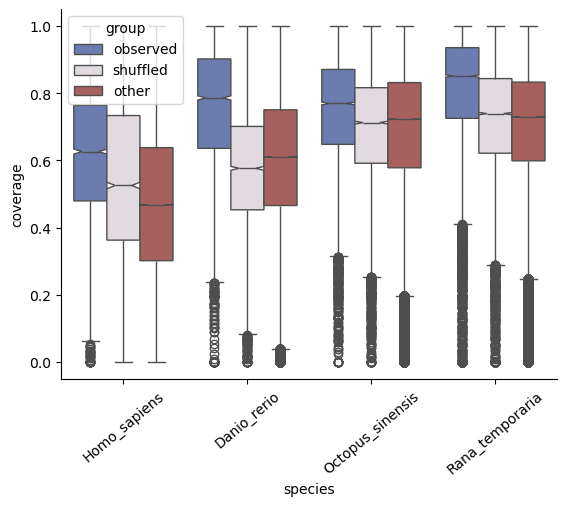

In [144]:
fig, ax = plt.subplots()
sns.boxplot(data=coverage_df.loc[coverage_df.length >= 1000], x='species', y='coverage', hue='group', notch=True, palette='twilight_shifted')
# ax.set_yscale('log')
sns.despine()
plt.xticks(rotation=40)
plt.show()

In [97]:
age_df = []

for species, accession in repeatmasker_files.items():
    print(species)
    te_bed, zf_bed = load_beds(species)
    zf_bed, shuffled_zf_bed = process_beds(species, te_bed, zf_bed)

    obs_df = zf_bed.intersect(b=te_bed, wb=True).to_dataframe(names=zf_bed_names+te_bed_names)
    shuf_df = shuffled_zf_bed.intersect(b=te_bed, wb=True).to_dataframe(names=zf_bed_names+te_bed_names)
    obs_df, shuf_df = label_dfs(obs_df, shuf_df)

    age_df.append(obs_df)
    age_df.append(shuf_df)

age_df = pd.concat(age_df)

Homo_sapiens


ValueError: too many values to unpack (expected 2)

In [ ]:
fig, ax = plt.subplots()
sns.violinplot(data=age_df, x='species', y='pdiv', hue='group')
# ax.set_yscale('log')
plt.xticks(rotation=70)
sns.despine()
plt.show()

In [8]:
age_df.head()

,zchrom,zstart,zend,chrom,start,end,tename,swscore,strand,pdiv,...,sleft,tetype,qstart,qend,qleft,repeat_id,species,group,tefam,teclass
0,QVAO01000059.1,3105,3253,QVAO01000059.1,3105,3253,DR002832680,920,-,7.9,...,(23128),Unspecified,(0),1020,879,4602,Ctenocephalides_felis,observed,Unspecified,Unspecified
1,QVAO01000059.1,3252,3897,QVAO01000059.1,3252,3897,DR002832529,4461,+,6.8,...,(22484),Unspecified,1257,1898,(0),4603,Ctenocephalides_felis,observed,Unspecified,Unspecified
2,QVAO01000059.1,3767,3913,QVAO01000059.1,3767,3913,DR002833259,748,+,13.2,...,(22468),Unspecified,4041,4186,(6052),4604,Ctenocephalides_felis,observed,Unspecified,Unspecified
3,QVAO01000059.1,3830,3944,QVAO01000059.1,3830,3944,DR002833259,261,+,20.3,...,(22437),Unspecified,3640,3748,(6490),4605,Ctenocephalides_felis,observed,Unspecified,Unspecified
4,QVAO01000059.1,5253,5578,QVAO01000059.1,5253,5578,DR002833548,1808,+,11.9,...,(20803),Unspecified,185,511,(702),4606,Ctenocephalides_felis,observed,Unspecified,Unspecified


In [4]:
pcdh_bed = bt.BedTool('../data/beds/Octopus_sinensis_protocadherins.bed').sort()
te_bed = bt.BedTool('../data/repeatmasker-out/Octopus_sinensis/GCF_006345805.1_ASM634580v1_genomic.fna.bed')
te_bed = bt.BedTool.from_dataframe(teclass_dfs['all'])
genomefile = '../data/genomes/GCF_006345805.1_ASM634580v1_genomic.genome'

merged_slopped_pdch_bed = pcdh_bed \
    .slop(g=genomefile,
          b=1e4) \
    .merge()
merged_slopped_pdch_bed = merged_slopped_pdch_bed.makewindows(w=5e3, b=merged_slopped_pdch_bed)
merged_slopped_shuffled_pdch_bed = merged_slopped_pdch_bed \
    .shuffle(g=genomefile)

obs_df = merged_slopped_pdch_bed.coverage(b=te_bed).to_dataframe()
shuf_df = merged_slopped_shuffled_pdch_bed.coverage(b=te_bed).to_dataframe()
obs_df['group'] = 'observed'
shuf_df['group'] = 'shuffled'

NameError: name 'teclass_dfs' is not defined

In [5]:
pdch_df = pd.concat([obs_df, shuf_df]).rename({'thickStart': 'coverage'}, axis=1)
pdch_df.shape

NameError: name 'obs_df' is not defined

In [1]:
fig, ax = plt.subplots()
sns.boxplot(data=pdch_df, x='group', y='coverage', notch=True, ax=ax)
sns.stripplot(data=pdch_df, x='group', y='coverage', ax=ax)
# ax.set_yscale('log')
sns.despine()
plt.show()

NameError: name 'plt' is not defined

In [75]:
tr_bed = bt.BedTool('../data/beds/Rana_temporaria_taste_receptors.bed').sort()
te_bed = bt.BedTool('../data/repeatmasker-out/Rana_temporaria/GCA_905171775.1_aRanTem1.1_genomic.fna.bed')
genomefile = '../data/genomes/GCA_905171775.1_aRanTem1.1_genomic.genome'

merged_slopped_tr_bed = tr_bed \
    .slop(g=genomefile,
          b=1e4) \
    .merge()
merged_slopped_tr_bed = merged_slopped_tr_bed.makewindows(w=5e3, b=merged_slopped_tr_bed)
merged_slopped_shuffled_tr_bed = merged_slopped_tr_bed \
    .shuffle(g=genomefile)

obs_df = merged_slopped_tr_bed.coverage(b=te_bed).to_dataframe()
shuf_df = merged_slopped_shuffled_tr_bed.coverage(b=te_bed).to_dataframe()
obs_df['group'] = 'observed'
shuf_df['group'] = 'shuffled'
tr_df = pd.concat([obs_df, shuf_df]).rename({'thickStart': 'coverage'}, axis=1)
tr_df.shape

(198, 8)

In [76]:
tr_df

,chrom,start,end,name,score,strand,coverage,group
0,LR991685.1,1605907,1610907,13,1923,5000,0.384600,observed
1,LR991685.1,1610907,1615907,18,4036,5000,0.807200,observed
2,LR991685.1,1615907,1620907,23,3697,5000,0.739400,observed
3,LR991685.1,1620907,1625907,19,4518,5000,0.903600,observed
4,LR991685.1,1625907,1630907,15,3172,5000,0.634400,observed
...,...,...,...,...,...,...,...,...
94,LR991680.1,181359978,181364978,25,3675,5000,0.735000,shuffled
95,LR991684.1,85794639,85799639,11,1369,5000,0.273800,shuffled
96,LR991688.1,15420,20420,8,671,5000,0.134200,shuffled
97,LR991684.1,399125007,399130007,7,4893,5000,0.978600,shuffled


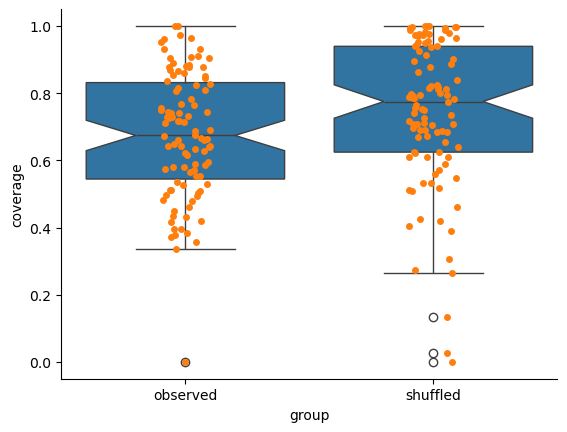

In [77]:
fig, ax = plt.subplots()
sns.boxplot(data=tr_df, x='group', y='coverage', notch=True)
sns.stripplot(data=tr_df, x='group', y='coverage')
# ax.set_yscale('log')
sns.despine()
plt.show()

In [152]:
coverage_df = []

te_bed, zf_bed, other_genes_bed = load_beds('Rana_temporaria', 'taste_receptors')
zf_bed, shuffled_zf_bed, control_genes_bed = process_beds('Rana_temporaria', te_bed, zf_bed, other_genes_bed)
# print(control_genes_bed.head())

obs_df = zf_bed.coverage(b=te_bed).to_dataframe()
shuf_df = shuffled_zf_bed.coverage(b=te_bed).to_dataframe()
genes_df = control_genes_bed.coverage(b=te_bed).to_dataframe()
obs_df, shuf_df, genes_df = label_dfs(obs_df, shuf_df, genes_df, 'Rana_temporaria')

coverage_df.append(obs_df)
coverage_df.append(shuf_df)
coverage_df.append(genes_df)

coverage_df = pd.concat(coverage_df).rename({'thickStart': 'coverage'}, axis=1)
coverage_df['length'] = abs(coverage_df.end - coverage_df.start)

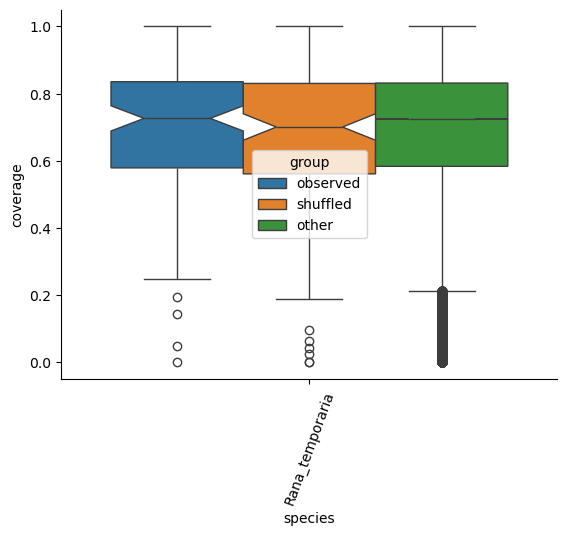

In [154]:
fig, ax = plt.subplots()
sns.boxplot(data=coverage_df.loc[coverage_df.length >= 500], x='species', y='coverage', hue='group', notch=True)
# ax.set_yscale('log')
sns.despine()
plt.xticks(rotation=70)
plt.show()